# MLBook Camp : Mid-Term Project

# Libraries

Below are the libraries required to run this project.

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import spacy
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# DATASET 
________________________________________________________________________________________________________________________________

# Data Description:

The data used in this project is from the Reddit forum ChangeMyView ([data](https://panda.uni-paderborn.de/pluginfile.php/1752026/mod_resource/content/1/test-data-prepared.json)). The online interactions between users with respect to any articles or news generally tend to turn into ad-hominem|(rude) posts. Due to such reasons, these conversations/comments are annotated by the forum. 

# Objective :

The classification goal here is to be able to predict the ad-hominem attacks in an online interaction between users, given a preceding dialogue. 

# Data Preparation

Before feeding the input to text pre-processing, the preceding posts are merged. 
The text preprocessing is done via spacy. 
Punctuations,spaces, urls, stop words are removed from the original text.

In [2]:
def read_data_file(path_to_file):
    with open('C:/Users/Amruta/Desktop/MLBoot/train-data-prepared.json', "r") as data_file:
        dialogues = json.load(data_file)
    return dialogues

In [3]:
# The preceding posts (dialogues) are merged to get the sequential information of the dialogues.

def merge_dialogue_texts(dialogues):
    preceding_posts_body = []
    full_dialogue_body = ''
    post_content = ''

    for dialogue in dialogues:
        for post in dialogue['preceding_posts']:
            post_content = post['body'].replace('\n', ' ').strip()
            post_content = post_content + ' ' if post_content.endswith(('?', '.', '!')) else post_content + '. '
            full_dialogue_body = full_dialogue_body + post_content
        preceding_posts_body.append(full_dialogue_body)
        full_dialogue_body = ''

    return preceding_posts_body

In [4]:
# Data cleaning : Punctuations,spaces, urls, stop words are removed from the original text.

def clean_dialogue_text(dialogue_text):
    parsed_dialogue_text = nlp(dialogue_text)
    tokenized_dialogue_clean_text = []
    for dialogue_token in parsed_dialogue_text:
        if (not dialogue_token.is_punct and
            not dialogue_token.is_space and
            not dialogue_token.like_url and
                not dialogue_token.is_stop):
            tokenized_dialogue_clean_text.append(dialogue_token.text)
    return tokenized_dialogue_clean_text

# Exploratory Data Analysis

In this section I have performed the below tasks:


- Features Analysis :
 
The majority of our features are keyword counts which are helpful to detect ad hominem inducing dialogues. The sequential structure of the posts is also used to extract sequential flag features.

    - There are 12 defined features used for this task and the top 150 features are taken from TfidfVectorizer.
    - The keyword count (feature name starts with “no_of_”)features are taken by merging and cleaning the posts.Then the count of those dialogues is taken.
    - The keyword count features are taken on the merged and cleaned dialogues and the sequential features are taken on the raw data.
    - The 12 defined features (including sequential features) are as follows:
        - no_of_uppercase_words: This feature contains the count of all the uppercase words.
        - no_of_nazi_words: This feature contains the count of the“nazi” keyword.
        - no_of_rape_words: This feature contains the count of the “rape” keyword.
        - no_of_racist_words: This feature contains the count of the “racist” keyword.
        - no_of_propaganda_words: This feature contains the count of the “propaganda” keyword.
        - no_of_vulgar_words: This feature contains the count of the vulgar keywords.
        - no_of_missing_evidence_words: This feature contains the count of the keywords “unsupported”,“unsubstantiated”.
        - no_of_fall_argument_words: This feature contains the count of the keywords “fallacy”, “fallacious”.
        - no_of_read_words: This feature contains the count of the keywords “reading”, “read”.
        - no_of_troll_words: This feature contains the count of the keywords “troll”, “trolls”, “trolling”.
        - flag_inc_vulgar_words: This feature is set to 1 if the vulgar words in the second preceding post are greater than the first preceding post else 0.
        - flag_inc_uppercase_words: This feature is set to 1 if the uppercase words in the second preceding post are greater than the first preceding post else 0.

- Dialogue Modelling : 
    - Model the dialogical/sequential information leading to ad-hominem posts.
    - The sequential/dialogical structure is modeled using the flag features.
    - The flag features (feature name starts with “flag_inc_”) check the two preceding posts and set the flags accordingly.
    
- Missing Features Analysis.
- Analysis of Target features.

In [5]:
# Dialogue data pre-processing 
def preprocess_text_data(dialogue_text_list):
    dialogue_text_list = [clean_dialogue_text(sentence) for sentence in dialogue_text_list]
    dialogue_text_list = [' '.join(document) for document in dialogue_text_list]
    return dialogue_text_list

In [6]:
# This function returns the number of uppercase_words

def count_uppercase_words(dialogues):
    no_of_uppercase_words = 0
    no_of_uppercase_words_list = []
    for merged_cleaned_dialogue in dialogues:
        for dialogue_token in merged_cleaned_dialogue.split():
            if dialogue_token.isupper():
                no_of_uppercase_words += 1
        no_of_uppercase_words_list.append(no_of_uppercase_words)
        no_of_uppercase_words = 0

    return no_of_uppercase_words_list

In [7]:
# This function checks for lowercase_words and returns its count

def count_keyword(merged_cleaned_dialogues, keyword):
    keyword_count = 0
    keyword_count_list = []
    for merged_cleaned_dialogue in merged_cleaned_dialogues:
        for dialogue_token in merged_cleaned_dialogue.split():
            if dialogue_token.lower() == keyword.lower():
                keyword_count += 1
        keyword_count_list.append(keyword_count)
        keyword_count = 0

    return keyword_count_list

In [8]:
# This function returns the number of vulgar words

def count_vulgar_words(dialogues):
    vulgar_words_list = ['anal', 'anus', 'ballsack', 'blowjob', 'boner', 'clitoris', 'cock', 'cunt',
                         'dick', 'dildo', 'dyke', 'fag', 'fuck', 'jizz', 'labia', 'muff', 'nigger',
                         'nigga', 'penis', 'piss', 'pussy', 'scrotum', 'sex', 'shit', 'slut',
                         'smegma', 'spunk', 'twat', 'vagina', 'wank', 'whore']

    vulgar_word_count_array = np.zeros(len(dialogues), dtype=int)

    for vulgar_word in vulgar_words_list:
        vulgar_word_count_array += np.array(count_keyword(dialogues, vulgar_word))

    return list(vulgar_word_count_array)


In [9]:
# This function returns the number of keywords array

def count_keywords(merged_cleaned_dialogues, keyword_list):
    keywords_word_count_array = np.zeros(len(merged_cleaned_dialogues), dtype=int)

    for keyword in keyword_list:
        keywords_word_count_array += np.array(count_keyword(merged_cleaned_dialogues, keyword))

    return list(keywords_word_count_array)


In [10]:
# This function returns the number of uppercase_words

def extract_sequential_features(dialogues):
    flag_inc_vulgar_words = []
    vulgar_words_temp_list = []
    flag_inc_uppercase_words = []
    uppercase_words_temp_list = []
    for dialogue in dialogues:
        vulgar_words_temp_list = count_vulgar_words([dialogue['preceding_posts'][0]['body'],
                                                     dialogue['preceding_posts'][1]['body']])
        flag_inc_vulgar_words.append(1 if vulgar_words_temp_list[0] < vulgar_words_temp_list[1] else 0)
        uppercase_words_temp_list = count_uppercase_words([dialogue['preceding_posts'][0]['body'],
                                                           dialogue['preceding_posts'][1]['body']])
        flag_inc_uppercase_words.append(1 if uppercase_words_temp_list[0] < uppercase_words_temp_list[1] else 0)

    return flag_inc_vulgar_words, flag_inc_uppercase_words


In [11]:
# The top 150 features are taken from TfidfVectorizer

def extract_tfidf_features(train_merged_cleaned_dialogues, test_merged_cleaned_dialogues, max_features):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1))
    train_tfidf_features = tfidf.fit_transform(train_merged_cleaned_dialogues)
    train_tfidf_features_df = pd.DataFrame(train_tfidf_features.todense(),
                                           columns=tfidf.get_feature_names())

    test_tfidf_features = tfidf.transform(test_merged_cleaned_dialogues)
    test_tfidf_features_df = pd.DataFrame(test_tfidf_features.todense(),
                                          columns=tfidf.get_feature_names())

    print(tfidf.get_feature_names())

    return train_tfidf_features_df, test_tfidf_features_df

In [12]:
# This function extracts the identified top features

def extract_features(merged_cleaned_dialogues, dialogues):
    features_df = pd.DataFrame()

    features_df['no_of_uppercase_words'] = count_uppercase_words(merged_cleaned_dialogues)
    features_df['no_of_nazi_words'] = count_keyword(merged_cleaned_dialogues, 'nazi')
    features_df['no_of_rape_words'] = count_keyword(merged_cleaned_dialogues, 'rape')
    features_df['no_of_racist_words'] = count_keyword(merged_cleaned_dialogues, 'racist')
    features_df['no_of_propaganda_words'] = count_keyword(merged_cleaned_dialogues, 'propaganda')
    features_df['no_of_vulgar_words'] = count_vulgar_words(merged_cleaned_dialogues)

    features_df['no_of_missing_evidence_words'] = count_keywords(merged_cleaned_dialogues,
                                                                 ['unsupported', 'unsubstantiated'])
    features_df['no_of_fall_argument_words'] = count_keywords(merged_cleaned_dialogues,
                                                              ['fallacy', 'fallacious'])
    features_df['no_of_read_words'] = count_keywords(merged_cleaned_dialogues,
                                                     ['reading', 'read'])
    features_df['no_of_troll_words'] = count_keywords(merged_cleaned_dialogues,
                                                      ['troll', 'trolls', 'trolling'])

    features_df['flag_inc_vulgar_words'], features_df['flag_inc_uppercase_words'] = \
        extract_sequential_features(dialogues)

    return features_df



# Classifier Models Training

I have chosen the below classifiers and have trained them with the best hyperparameters.
- Perceptron
- Logistic Regression
- NeuralNetworks(MLP)
- SVM
- Random Forest
- kNearest Neighbour

### Neural Networks: MLPClassifier 

In [13]:
def train_nn_and_save_results(X_train, y_train, X_test, test_argument_id_list, nn_best_params_dict):
    clf = MLPClassifier(**nn_best_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_neural_networks.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)

### Perceptron 

In [14]:
def train_perceptron_and_save_results(X_train, y_train, X_test, test_argument_id_list, perceptron_best_params_dict):
    clf = Perceptron(**perceptron_best_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_perceptron.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)


### KNeighbors Classifier 

In [15]:
def train_kNN_and_save_results(X_train, y_train, X_test, test_argument_id_list, kNN_best_params_dict):
    clf = KNeighborsClassifier(**kNN_best_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_kNN.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)

### Support Vector Classifier (SVC)

In [16]:
def train_svm_and_save_results(X_train, y_train, X_test, test_argument_id_list, svm_best_params_dict):
    clf = SVC(**svm_best_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_svm.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)

### Logistic Regression

In [17]:
def train_lr_and_save_results(X_train, y_train, X_test, test_argument_id_list, lr_best_params_dict):
    clf = LogisticRegression(**lr_best_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_lr.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)

### Random Forest Classifier

In [18]:
def train_random_forest_and_save_results(X_train, y_train, X_test, test_argument_id_list, random_forest_params_dict):
    clf = RandomForestClassifier(**random_forest_params_dict)
    clf.fit(X_train, y_train)
    prediction_list = clf.predict(X_test)
    prediction_list = [int(pred) for pred in prediction_list]

    prediction_dict = {}
    for index in range(len(prediction_list)):
        prediction_dict[test_argument_id_list[index]] = prediction_list[index]

    with open('predictions_random_forest.json', 'w') as pred_file:
        json.dump(prediction_dict, pred_file, indent=4)


# Hyperparameter Optimization:

The aim here is to optimize the hyperparameters (on the training dataset) used in the above mentioned classifiers. In this step, we perform a cross-validation on the training dataset and get the best hyperparameters for our classifiers. I have used GridSearchCV in Python.

### Perceptron

In [19]:
def hp_optimize_perceptron(X_train, y_train):
    param_grids = [
        {
            "penalty": ["l2", "l1", "elasticnet"],
            "alpha": [0.0001, 0.001, 0.01, 0.1],
            "max_iter": [1000, 1500, 2000, 2500, 3000]
        }
    ]

    grid_clf = Perceptron()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("Perceptron best params:" + str(grid_search.best_params_))
    return grid_search.best_params_


### KNeighbors Classifier

In [20]:
def hp_optimize_kNN(X_train, y_train):
    param_grids = [
        {
            "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    ]

    grid_clf = KNeighborsClassifier()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("kNN best params:" + str(grid_search.best_params_))
    return grid_search.best_params_

### Neural Networks: MLPClassifier 

In [21]:
def hp_optimize_nn(X_train, y_train):
    param_grids = [
        {
            "alpha": [0.0001, 0.001, 0.01, 0.1],
            "activation": ["logistic", "tanh", "relu"],
            "max_iter": [1500],
            "hidden_layer_sizes": [(6, 4, 2), (6, 3)]
        }
    ]

    grid_clf = MLPClassifier()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("NN best params:" + str(grid_search.best_params_))
    return grid_search.best_params_


### SVC

In [22]:
def hp_optimize_svm(X_train, y_train):
    param_grids = [
        {
            "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            "gamma": ["scale"],
            "kernel": ["linear", "poly", "rbf"]
        }
    ]

    grid_clf = SVC()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("SVM best params:" + str(grid_search.best_params_))
    return grid_search.best_params_


### Logistic Regression

In [23]:
def hp_optimize_lr(X_train, y_train):
    param_grids = [
        {
            "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            "max_iter": [300, 400, 500]
        }
    ]

    grid_clf = LogisticRegression()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("Logistic Regression best params:" + str(grid_search.best_params_))
    return grid_search.best_params_


### Random Forest Classifier

In [24]:
def hp_optimize_random_forest(X_train, y_train):
    param_grids = [
        {
            "n_estimators": [25, 50, 75, 100]
        }
    ]

    grid_clf = RandomForestClassifier()

    grid_search = GridSearchCV(grid_clf, param_grid=param_grids, cv=3, n_jobs=-1
                               , scoring="f1")
    grid_search.fit(X_train, y_train)

    print("Random Forest best params:" + str(grid_search.best_params_))
    return grid_search.best_params_

# Training Models

In [25]:
nlp = spacy.load("en_core_web_sm")

train_dialogues = read_data_file('C:/Users/Amruta/Desktop/MLBoot/train-data-prepared.json')
train_merged_cleaned_dialogues = preprocess_text_data(merge_dialogue_texts(train_dialogues))

X_train = extract_features(train_merged_cleaned_dialogues, train_dialogues)
y_train = pd.Series(data=np.array([dialogue['label'] for dialogue in train_dialogues]))

test_file_path = sys.argv[1]

test_dialogues = read_data_file(test_file_path)
test_merged_cleaned_dialogues = preprocess_text_data(merge_dialogue_texts(test_dialogues))

X_test = extract_features(test_merged_cleaned_dialogues, test_dialogues)
y_test = pd.Series(data=np.array([dialogue['label'] for dialogue in test_dialogues]))

train_tfidf_features_df, test_tfidf_features_df = extract_tfidf_features(train_merged_cleaned_dialogues,
                                                                         test_merged_cleaned_dialogues, 150)

X_train = pd.concat([X_train, train_tfidf_features_df], axis=1)
X_test = pd.concat([X_test, test_tfidf_features_df], axis=1)

print(X_train)
print(y_train)
print(X_test)
print(y_test)

test_id_list = [dialogue['id'] for dialogue in test_dialogues]


['able', 'absolutely', 'actually', 'agree', 'argue', 'argument', 'away', 'bad', 'based', 'believe', 'best', 'better', 'black', 'care', 'case', 'change', 'child', 'children', 'claim', 'come', 'comment', 'completely', 'country', 'course', 'culture', 'day', 'definition', 'different', 'discussion', 'end', 'etc', 'evidence', 'exactly', 'example', 'experience', 'fact', 'far', 'feel', 'find', 'free', 'gender', 'getting', 'going', 'good', 'got', 'government', 'group', 'hard', 'having', 'help', 'human', 'idea', 'important', 'instead', 'issue', 'job', 'kill', 'kind', 'know', 'law', 'let', 'life', 'like', 'likely', 'literally', 'little', 'live', 'long', 'look', 'lot', 'majority', 'makes', 'making', 'man', 'matter', 'maybe', 'mean', 'means', 'men', 'money', 'need', 'new', 'non', 'nt', 'op', 'opinion', 'pay', 'people', 'person', 'personal', 'place', 'point', 'political', 'poor', 'post', 'power', 'pretty', 'probably', 'problem', 'public', 'question', 'racist', 'rape', 'read', 'real', 'reason', 'righ

## Hyperparameters for each trained classifier

In [26]:
# Perceptron
perceptron_best_params_dict = hp_optimize_perceptron(X_train, y_train)
train_perceptron_and_save_results(X_train, y_train, X_test, test_id_list, perceptron_best_params_dict)

# Neural Netwroks: MLP Classifier
nn_best_params_dict = hp_optimize_nn(X_train, y_train)
train_nn_and_save_results(X_train, y_train, X_test, test_id_list, nn_best_params_dict)

# KNeigbors Classifier
kNN_best_params_dict = hp_optimize_kNN(X_train, y_train)
train_kNN_and_save_results(X_train, y_train, X_test, test_id_list, kNN_best_params_dict)

# SVM 
svm_best_params_dict = hp_optimize_svm(X_train, y_train)
train_svm_and_save_results(X_train, y_train, X_test, test_id_list, svm_best_params_dict)

# Logistic Regression
lr_best_params_dict = hp_optimize_lr(X_train, y_train)
train_lr_and_save_results(X_train, y_train, X_test, test_id_list, lr_best_params_dict)

# Random Forest Classifier
random_forest_params_dict = hp_optimize_random_forest(X_train, y_train)
train_random_forest_and_save_results(X_train, y_train, X_test, test_id_list, random_forest_params_dict)


Perceptron best params:{'alpha': 0.0001, 'max_iter': 1000, 'penalty': 'l1'}
NN best params:{'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (6, 4, 2), 'max_iter': 1500}
kNN best params:{'n_neighbors': 5}
SVM best params:{'C': 100.0, 'gamma': 'scale', 'kernel': 'linear'}
Logistic Regression best params:{'C': 10.0, 'max_iter': 300}
Random Forest best params:{'n_estimators': 100}


# Predictions

After running above cells, the predictions file “predictions_(name_of_classifier).json” will be generated in the main folder which will contain all the predictions for the desired test file. I have created an evaluation python script as well to check the prediction f1 score for the desired test file. <br> 

Run the evaluation script on training data using the following command:<br>
*$ python eval.py -t (path-to-ground-truth-file)  -p   (path-to-predictions-file)*

Example:<br>
 *$ python eval.py -t train-data-prepared.json -p predictions_svm.json*
 
 Similarily, run the eval script on validation data using the following command : <br>
 *$ python eval.py -t (path-to-ground-truth-file)  -p   (path-to-predictions-file)*
 
 Example:<br>
 *$ python eval.py -t val-data-prepared.json -p predictions_svm.json*

# Results

### Prediction Scores :

After training on all classifiers, we found out that the best performing
model is SVM with a f1 score of 0.70 on the validation dataset. To
check for overfitting, we also had a look at the f1 score on the
training dataset which is 0.74 which means both the f1 scores are
quite similar so there is no overfitting on the training dataset.

### Output :

The results of the classifier SVM on the training and validation set are
shown below.

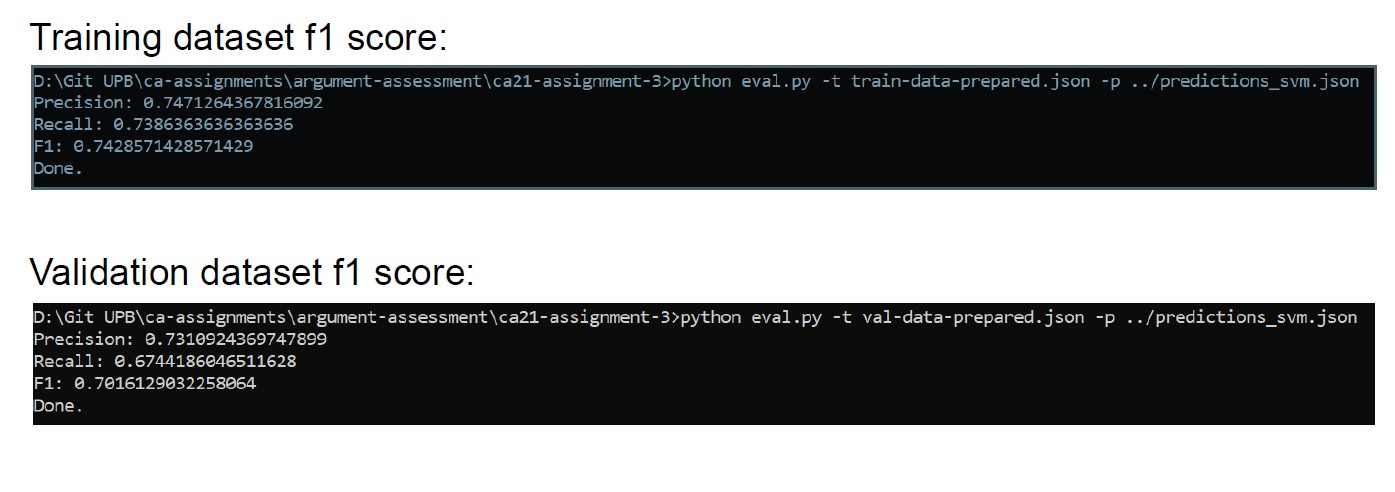